# Project of Machine Learning : Adversarial attacks

#### Loading data and Normalizing

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import torch.optim as optim
from tqdm import tqdm
import os

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [ ]:
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys() :
  print('User uploaded file "{name}" with length {length} bytes'.format(
     name=fn, length=len(uploaded[fn])))

Saving cifar_net_CLASSIC_10epochs.pth to cifar_net_CLASSIC_10epochs.pth
User uploaded file "cifar_net_CLASSIC_10epochs.pth" with length 683061 bytes


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imsave(img, count=None, categorie=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if count != None and categorie != None :
      plt.savefig("{}_images_{}".format(count, categorie))
    #plt.show()

#### Clean definition of all the iterator over Data

In [ ]:
def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


def data_loading(set_data, repartition_train_valid, b_size, training=False):
  if training :
    print("Loading of Training and Validation sets !")
    datasets = train_val_dataset(set_data, repartition_train_valid)
    dataloaders = {x : torch.utils.data.DataLoader(datasets[x], batch_size=b_size, shuffle=True, num_workers=2) for x in ['train','val']}
    trainloader = dataloaders['train']
    validloader = dataloaders['val']
    return trainloader, validloader
  
  else :
    print("Loading of the Test set !")
    testloader = torch.utils.data.DataLoader(set_data, batch_size=b_size,
                                              shuffle=True, num_workers=2)
    return testloader

#### Class of our CNN

In [ ]:
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        self.dropout1 = nn.Dropout(p=0.2, inplace=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
      

    def fit(self, train_set, test_set, batch_size, nb_epochs, criterion, learning_r, DEVICE):
      train, valid = data_loading(train_set, 0.1, batch_size, training=True)
      test = data_loading(test_set, 0.1, batch_size, training=False)
      optimizer = optim.SGD(self.parameters(), lr=learning_r, momentum=0.9)
      
      loss_total = []
      valid_loss_total = []
      acc_total = []

      for epoch in range(nb_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        valid_loss = 0.0
        temp = []
        for i, data in enumerate(train, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = self.forward(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          nbr_ref = int(( 5400 / (batch_size / 4) ))

          if i % nbr_ref == nbr_ref - 1:    # print every XXX mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / nbr_ref ))
              
              temp.append(running_loss/nbr_ref)
              running_loss = 0.0
        loss_total.append(np.mean(temp))
        
        with torch.no_grad():
          temp = []
          for i, data in enumerate(valid, 0):
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

            # forward + backward + optimize
            outputs = self.forward(inputs)
            loss_valid = criterion(outputs, labels)

            # print statistics
            valid_loss += loss_valid.item()
            nbr_ref = int(( 600 / (batch_size / 4) ))
            if i % nbr_ref == nbr_ref - 1:    # print every XXX mini-batches
              print('[%d, %5d] valid loss: %.3f' %
                    (epoch + 1, i + 1, valid_loss/nbr_ref))
              
              temp.append(valid_loss/nbr_ref)
              valid_loss = 0.0
          valid_loss_total.append(np.mean(temp))
        
        correct = 0
        total = 0
        with torch.no_grad():
          for data in test :
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = self.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        acc_total.append(100 * correct / total)
      print('Finished Training')
      return acc_total, loss_total, valid_loss_total



    def test(self, test_set, batch_size):
      test = data_loading(test_set, 0.1, batch_size, training=False)
      correct = 0
      total = 0
      confusion_matrix = np.zeros([10,10], int)
      with torch.no_grad():
          for data in test :
              inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
              outputs = self.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              for i, l in enumerate(labels):
                  confusion_matrix[l.item(), predicted[i].item()] += 1 

      acc_total = 100 * correct / total
      print('Accuracy of the network on the 10000 test images: %d %%' % (
          acc_total ))
      
      resultats = []
      print('{0:10s} - {1}'.format('Category','Accuracy'))
      for i, r in enumerate(confusion_matrix):
          print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))
          resultats.append('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

      return acc_total, confusion_matrix, resultats

In [ ]:
net = Net()
PATH = './cifar_net_CLASSIC_10epochs.pth'
net.load_state_dict(torch.load(PATH))
net.to(DEVICE)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
)

In [ ]:
next(net.parameters()).is_cuda

True

### L$oo$ - PGD attack and Robustness of the Classic CNN

In [ ]:
def distance_plot_delta(X_batch, X_att):
  return torch.mean( torch.norm(X_att - X_batch, dim=1) )

In [ ]:
def pgd_attack(model_cnn, device, X_batch, y_batch, loss_model, nb_it=7, eta=2 / 255, epsilon=8 / 255):
    model_cnn.to(device)
    epsilon, eta = epsilon / 0.5, eta / 0.5
    delta = nn.Parameter(torch.zeros(X_batch.shape, requires_grad=True, device=device))
    for it in range(nb_it):
        loss = loss_model(model_cnn(X_batch + delta), y_batch)
        loss.backward()
        delta.data = (delta + eta * torch.sign(delta.grad.data)).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    X_att = X_batch + delta
    return X_att.detach()

### Defense : Adversarial training

In [ ]:
# Training avec 100% de données attaquées et observations
model = Net()
model.to(DEVICE)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
)

In [ ]:
accs = [[], []]
optimizerr = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in tqdm(range(10)) :  # loop over the dataset multiple times

  for i, data in enumerate(trainloader, 0):
  # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
    inputs_att = pgd_attack(net, DEVICE, inputs, labels, torch.nn.CrossEntropyLoss())

    # zero the parameter gradients
    optimizerr.zero_grad()
    outputs_att = model(inputs_att)
    loss_pgd = nn.CrossEntropyLoss()(outputs_att, labels)
    loss_pgd.backward()
    optimizerr.step()

  correct = 0
  total = 0
  correct_att = 0

  #with torch.no_grad():
  for data in testloader :
    inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
    inputs_att = pgd_attack(net, DEVICE, inputs, labels, torch.nn.CrossEntropyLoss())

    outputs = model(inputs)
    outputs_att = model(inputs_att)
    _, predicted = torch.max(outputs.data, 1)
    _, predicted_att = torch.max(outputs_att.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    correct_att += (predicted_att == labels).sum().item()

  accs[0].append(100 * correct / total)
  print("Accuracy on clean images : ", 100 * correct / total)
  accs[1].append(100 * correct_att / total)
  print("Accuracy on clean images : ", 100 * correct_att / total)

print('\nFinished Training')


 10%|█         | 1/10 [04:54<44:09, 294.41s/it]

Accuracy on clean images :  34.45
Accuracy on clean images :  32.99



 20%|██        | 2/10 [09:44<39:05, 293.14s/it]

Accuracy on clean images :  44.79
Accuracy on clean images :  42.07



 30%|███       | 3/10 [14:24<33:43, 289.14s/it]

Accuracy on clean images :  51.51
Accuracy on clean images :  47.87



 40%|████      | 4/10 [19:01<28:33, 285.52s/it]

Accuracy on clean images :  52.21
Accuracy on clean images :  51.09



 50%|█████     | 5/10 [23:44<23:43, 284.69s/it]

Accuracy on clean images :  53.1
Accuracy on clean images :  57.58



 60%|██████    | 6/10 [28:16<18:43, 280.95s/it]

Accuracy on clean images :  51.07
Accuracy on clean images :  60.25



 70%|███████   | 7/10 [32:47<13:53, 277.91s/it]

Accuracy on clean images :  51.21
Accuracy on clean images :  64.84



 80%|████████  | 8/10 [37:16<09:10, 275.38s/it]

Accuracy on clean images :  51.22
Accuracy on clean images :  64.2



 90%|█████████ | 9/10 [41:46<04:33, 273.76s/it]

Accuracy on clean images :  51.99
Accuracy on clean images :  66.9



100%|██████████| 10/10 [46:16<00:00, 277.69s/it]

Accuracy on clean images :  53.96
Accuracy on clean images :  65.94

Finished Training


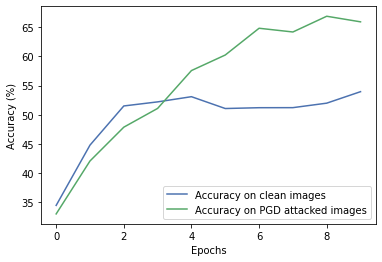

In [ ]:
plt.style.use('seaborn-deep')
plt.plot(accs[0], label="Accuracy on clean images")
plt.plot(accs[1], label="Accuracy on PGD attacked images")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.savefig("AdvTRAIN_accuracies_clean_att.png", dpi=1000)
plt.show()

In [ ]:
accu, confu_m, results = model.test(testset, 64)

Loading of the Test set !
Accuracy of the network on the 10000 test images: 53 %
Category   - Accuracy
plane      - 68.8
car        - 66.7
bird       - 49.4
cat        - 47.0
deer       - 30.2
dog        - 48.7
frog       - 60.0
horse      - 59.0
ship       - 51.2
truck      - 56.9


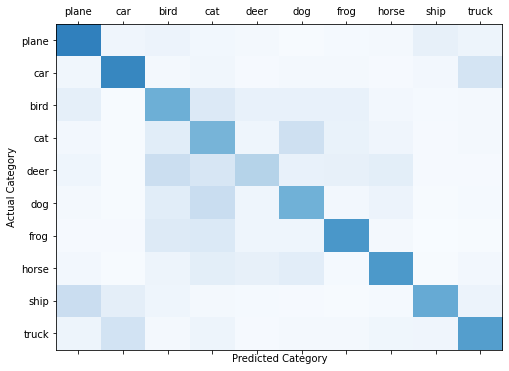

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confu_m, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.savefig("Confusion_matrix")
plt.show()

In [ ]:
PATH = './cifar_net_AdvTRAIN_10epochs.pth'

In [ ]:
torch.save(model.state_dict(), PATH)

In [ ]:
a, b, c = net.test(testset, 64)

Loading of the Test set !
Accuracy of the network on the 10000 test images: 68 %
Category   - Accuracy
plane      - 77.5
car        - 87.6
bird       - 41.6
cat        - 54.3
deer       - 66.6
dog        - 65.4
frog       - 73.3
horse      - 70.7
ship       - 72.9
truck      - 77.6
